# Final Project: FEC Campaign Donations
## Lincoln Swaine-Moore

In [160]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
import pandas
import math
import datetime
import re

#clustering
from sklearn.neighbors.kde import KernelDensity
from sklearn.neighbors import NearestNeighbors
from astroML.density_estimation import KDE,KNeighborsDensity
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.grid_search import GridSearchCV
from matplotlib.colors import LogNorm

#classification
from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.lda import LDA
from sklearn.qda import QDA

from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
from scipy import interp


import seaborn as sns
from scipy import optimize

## Preparing data

In [2]:
#READ IN FEC DATA

#http://stackoverflow.com/questions/23436681/why-is-my-column-data-is-off-by-one-in-pandas
colnames = ["cmte_id","cand_id","cand_nm","contbr_nm","contbr_city","contbr_st","contbr_zip","contbr_employer","contbr_occupation","contb_receipt_amt","contb_receipt_dt","receipt_desc","memo_cd","memo_text","form_tp","file_num","tran_id","election_tp"]
original = pandas.read_table("P00000001-ALL.csv",sep = ",",low_memory=False, names=colnames, dtype = {"contbr_zip":object})
original = original[original.cmte_id != "cmte_id"]
original = original.reset_index()
original = original.drop("index",1)

In [3]:
#GET RID OF BAD VALUES

relevant = original
print(len(relevant))


#GET RID OF BAD ZIP CODES

#http://stackoverflow.com/questions/22290000/filtering-a-dataframe-based-on-a-regex
relevant = relevant[relevant.contbr_zip.str.contains('^\d+$', regex=True, na=False)]
relevant = relevant.reset_index()
relevant = relevant.drop("index",1)
print(len(relevant))


#GET RID OF DONATIONS WITH RECEIPT DESCRIPTIONS (MOSTLY REALLOCATIONS)

relevant = relevant[relevant.receipt_desc.isnull()]
# relevant = relevant[relevant.memo_cd.isnull()]
# relevant = relevant[relevant.memo_text.isnull()]
print(len(relevant))

2578106
2577720
2533442


In [4]:
#SELECT COLUMNS WE WANT

relevant = relevant[["cand_nm","contbr_city","contbr_st","contbr_zip","contbr_employer","contbr_occupation","contb_receipt_amt","contb_receipt_dt"]]

In [5]:
#MAKE A ZIP5 COLUMN

relevant["contbr_zip5"] = relevant.contbr_zip.str[0:5]

In [6]:
#READ IN ZIP DATA

zips = pandas.read_table("zipcode.csv",sep = ",",low_memory=False,dtype = {"zip":object})

In [7]:
#MERGE ON STATE AND ZIP (NOT CITY BECAUSE I DIDN'T WANT TO CLEAN IT)

#http://stackoverflow.com/questions/20375561/joining-pandas-dataframes-by-column-names
merged = pandas.merge(relevant, zips, how = "left", left_on=["contbr_zip5","contbr_st"], right_on=["zip","state"])

In [8]:
#http://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-of-certain-column-is-nan
test = merged[pandas.notnull(merged.state)]
print("total number matched: " + str(np.sum(pandas.notnull(merged.state))))
# print("mismatched: " + str(np.sum(test.contbr_st != test.state)))
print("total length: " + str(len(merged.contbr_st)))

total number matched: 2496660
total length: 2533442


In [9]:
#GET RID OF DUPLICATE AND USELESS COLUMNS

merged = merged.drop(["zip","city","state","dst"],1)

In [10]:
#SPLIT OUT DATE INFO

merged["day_of_month"] = merged.contb_receipt_dt.str[0:2]
merged["month"] = merged.contb_receipt_dt.str[3:6]
merged["year"] = merged.contb_receipt_dt.str[7:9]

def month_to_num(m):
    if m == "JAN":
        return 1
    elif m == "FEB":
        return 2
    elif m == "MAR":
        return 3
    elif m == "APR":
        return 4
    elif m == "MAY":
        return 5
    elif m == "JUN":
        return 6
    elif m == "JUL":
        return 7
    elif m == "AUG":
        return 8
    elif m == "SEP":
        return 9
    elif m == "OCT":
        return 10
    elif m == "NOV":
        return 11
    elif m == "DEC":
        return 12
merged['month_int'] = merged.month.apply(month_to_num,1)
    
#ABSOLUTE DATE
def date_to_num(full):
    day_of_month = int(full[0:2])
    month = int(month_to_num(full[3:6]))
    year = int("20" + full[7:9])
    
    d = datetime.date(year, month, day_of_month)

    return d.toordinal()
    
merged['date_int'] = merged.contb_receipt_dt.apply(date_to_num,1)
merged['relative_date_int'] = merged.date_int - np.min(merged.date_int)


In [11]:
#REPLACE NAMES WITH LAST NAMES

def name_to_last(name):
    return re.split(",", name)[0]

merged['cand_nm'] = merged.cand_nm.apply(name_to_last,1)

In [12]:
#COERCE TYPES

merged['day_of_month'] = merged['day_of_month'].astype(int)
merged['year'] = merged['year'].astype(int)
merged['month_int'] = merged['month_int'].astype(int)
merged['date_int'] = merged['date_int'].astype(int)
merged['relative_date_int'] = merged['relative_date_int'].astype(int)


merged['latitude'] = merged['latitude'].astype(float)
merged['longitude'] = merged['longitude'].astype(float)
merged['contb_receipt_amt'] = merged['contb_receipt_amt'].astype(float)

In [13]:
# DROP NEGATIVE DONATIONS

merged = merged[merged.contb_receipt_amt >= 0]

In [14]:
final = merged

In [15]:
#SPLIT OUT BY CANDIDATE

by_candidate = {}
big_by_candidate = {}

all_candidates = final.cand_nm.unique()

for c in all_candidates:
    by_candidate[c] = final[final.cand_nm == c]
    if len(by_candidate[c]) > 5000:
        big_by_candidate[c] = by_candidate[c]
    


In [16]:
#CREATE AN ALTERNATE DATASET THAT ONLY HAS THE MAJOR CANDIDATES

final_big_cand = final[final.cand_nm.isin(big_by_candidate.keys())]
final_big_cand.cand_nm.unique()

array(['Rubio', 'Carson', 'Cruz', 'Paul', 'Clinton', 'Sanders', 'Fiorina',
       'Huckabee', "O'Malley", 'Bush', 'Trump', 'Christie', 'Walker',
       'Kasich'], dtype=object)

In [17]:
# CREATE AN ALTERNATE DATASET THAT HAS EVEN NUMBER OF ENTRIES FOR ONLY THE MAJOR CANDIDATES

final_big_cand.cand_nm.value_counts()

final_even = pandas.DataFrame(columns=list(final_big_cand.columns.values))

for cand in big_by_candidate.keys():
    dat = big_by_candidate[cand]
    dat = dat.sample(5000)
#     print dat
#     print(type(dat))
    final_even = final_even.append(dat)

In [19]:
final_big_cand.cand_nm.value_counts()

Sanders     1154321
Clinton      491423
Cruz         400513
Carson       241934
Rubio         95064
Paul          32066
Fiorina       27313
Bush          26796
Kasich        19182
Trump          9764
Huckabee       6348
Walker         6058
Christie       5440
O'Malley       5109
dtype: int64

In [20]:
# CREATE AN ALTERNATE DATASET THAT HAS EVEN NUMBER OF CANDIDATES FOR HILLARY CLINTON AND BERNIE SANDERS

sizeper = 100000

final_clinton_sanders = pandas.DataFrame(columns=list(final_big_cand.columns.values))

#append clinton
c = big_by_candidate["Clinton"].sample(sizeper)
final_clinton_sanders = final_clinton_sanders.append(c)

#append sanders
s = big_by_candidate["Sanders"].sample(sizeper)
final_clinton_sanders = final_clinton_sanders.append(s)

## Exploratory Analysis

In [48]:
sample = final.sample(100000)
print np.max(sample.contb_receipt_amt)
print np.min(sample.contb_receipt_amt)

10800.0
0.0


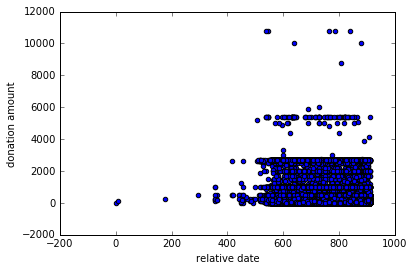

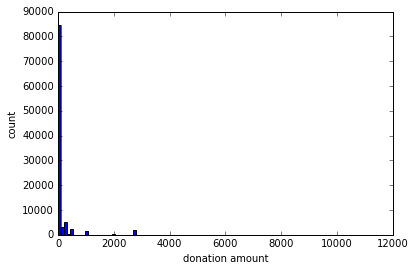

In [49]:
plt.scatter(sample.relative_date_int, sample.contb_receipt_amt)
plt.xlabel("relative date")
plt.ylabel("donation amount")
plt.show()
plt.hist(sample.contb_receipt_amt,bins=100)
plt.xlabel("donation amount")
plt.ylabel("count")
plt.show()

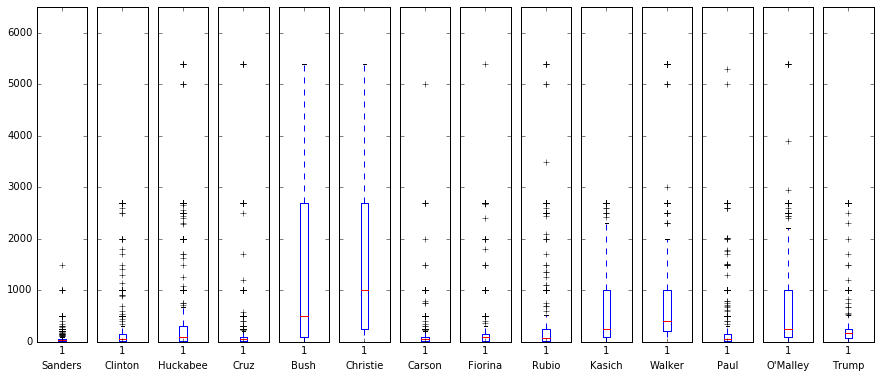

In [52]:
#http://matplotlib.org/examples/pylab_examples/boxplot_demo2.html

f, axarr = plt.subplots(1,len(big_by_candidate.keys()), sharey=True,figsize=(15, 6))
# f,axarr = plt.subplots(figsize=(15,6))
# axarr.set_xlabel("Candidate")
# axarr.set_ylabel("Donation size in dollars")

for i,cand in enumerate(big_by_candidate.keys()):
    dat = big_by_candidate[cand]
#     print cand
#     print len(np.array(dat.contb_receipt_amt))
    cand_sample = dat.sample(1000)
#     axarr[i] = plt.subplot(1,3,1+i)
    axarr[i].boxplot(np.array(cand_sample.contb_receipt_amt))
    axarr[i].set_ylim([0,6500])
    axarr[i].set_xlabel(cand)
#     bp.show()

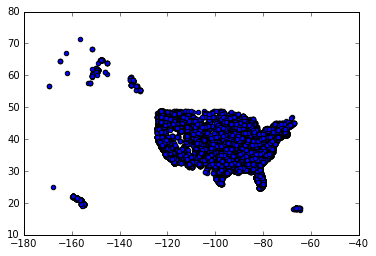

In [19]:
nona = sample.dropna()
plt.scatter(nona.longitude, nona.latitude)
plt.show()

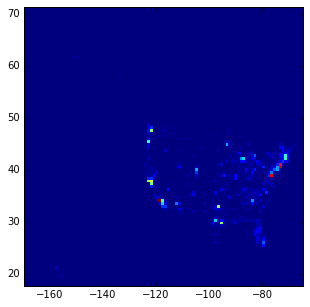

In [20]:
nona = sample.dropna()
h, x_e, y_e = np.histogram2d(nona.latitude, nona.longitude,bins = 100,normed=True)
plt.figure(figsize=(5, 5))
plt.imshow(h, interpolation='nearest', origin='low',
                extent=[y_e[0], y_e[-1],x_e[0], x_e[-1]])
plt.axis('tight')
plt.show()

## Time Analysis

In [124]:
week_bins = np.arange(np.min(final.relative_date_int),np.max(final.relative_date_int),7)
weeks = np.arange(1,len(week_bins))
weeks_count = np.zeros(len(weeks))
for i in range(0, len(week_bins) - 1):
    this_week = final[(final.relative_date_int >= week_bins[i]) & (final.relative_date_int < week_bins[i+1])]
    weeks_count[i] = len(this_week)

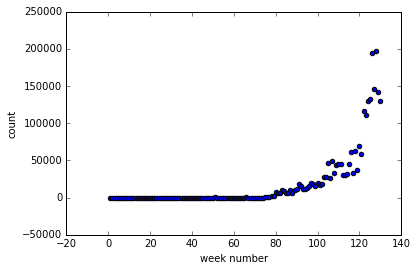

In [129]:
plt.scatter(weeks,weeks_count)
plt.xlabel("week number")
plt.ylabel("count")
plt.show()

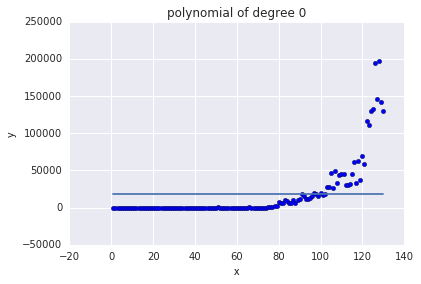

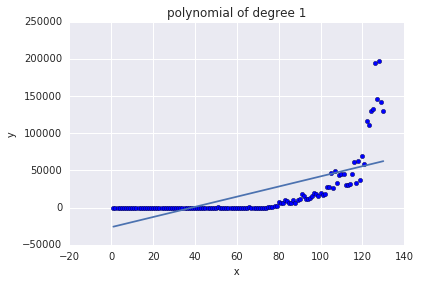

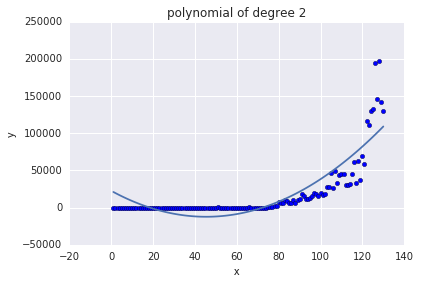

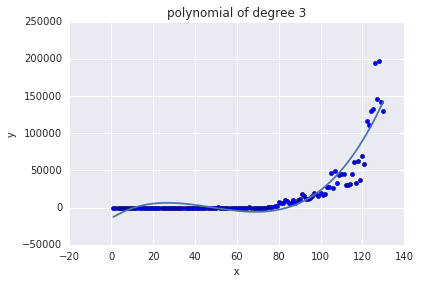

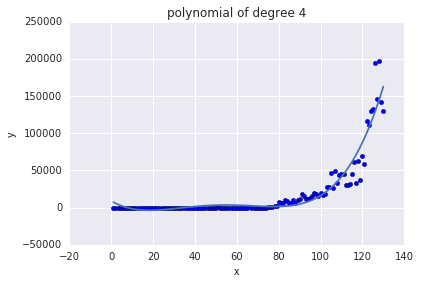

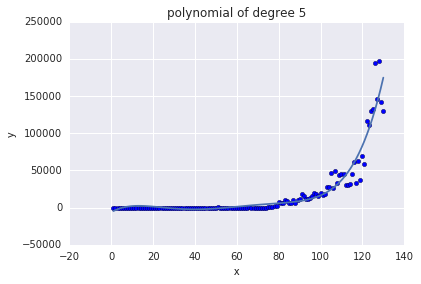

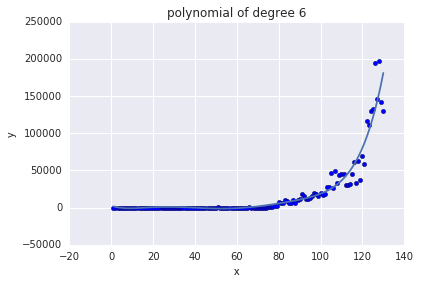

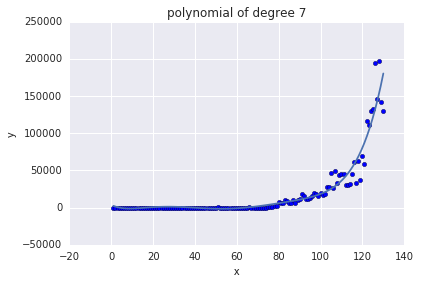

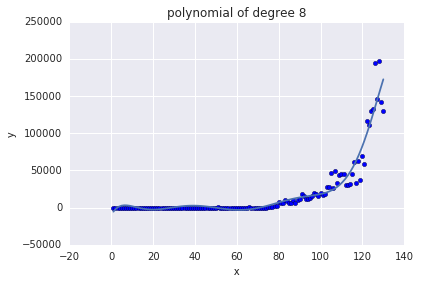

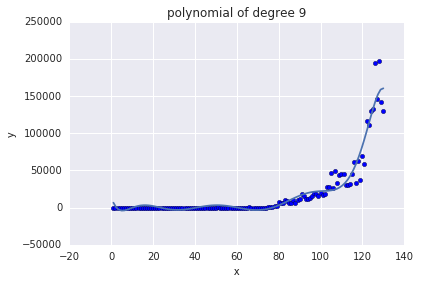

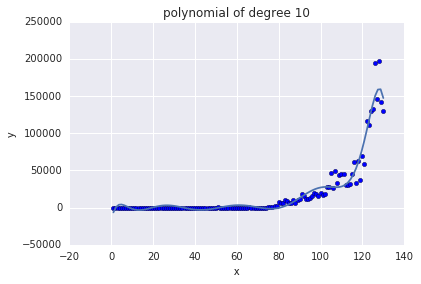

In [192]:
#adapted from problem set 3, adapted from http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.polyfit.html

x = weeks
y = weeks_count

results = []
for i in range(0,11):
    results.append(np.polyfit(x, y, i))
    
# for i in range(0,11):
for i in range(0,11):
    plt.scatter(x,y)
    p = np.poly1d(results[i])
#     print(results[i])
    xp = np.linspace(np.min(x), np.max(x), 100)
    plt.plot(xp,p(xp))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("polynomial of degree " + str(i))
    plt.show()

## A lot of the below is adapted from Problem Set 4, which in turn was adapted from Jake Vanderplaas. Pretty much all of the code written for the rest of this part is directly from or modeled on code from http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/.

In [ ]:
data = (weeks, weeks_count)

### Priors/Likelihood/Posterior

In [180]:
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
#     return sum(t * x ** n for (n, t) in enumerate(theta))
    p = np.poly1d(results[i])
    return p(x)

def log_prior(theta):
    # size of theta determines the model.
    # flat prior over a large range
    if np.any(abs(theta) > 10000):
        return -np.inf  # log(0)
    else:
        return - np.log(2000) ** len(theta)

def log_likelihood(theta, data=data):
    x, y = data
    yM = polynomial_fit(theta, x)
    return -0.5 * np.sum(np.log(2 * np.pi)
                         + (y - yM) ** 2)

def log_posterior(theta, data=data):
    theta = np.asarray(theta)
    return log_prior(theta) + log_likelihood(theta, data)

In [191]:
for i in range(0,10):
    print "maximum loglikelihood for " + str(i) + " order polynomial: " + str(log_likelihood(results[i]))

maximum loglikelihood for 0 order polynomial: -96208755086.7
maximum loglikelihood for 1 order polynomial: -53567619082.5
maximum loglikelihood for 2 order polynomial: -24006022962.9
maximum loglikelihood for 3 order polynomial: -12463479859.4
maximum loglikelihood for 4 order polynomial: -9097239479.85
maximum loglikelihood for 5 order polynomial: -8029823974.21


### AIC/BIC

In [183]:
def BIC(LL, k, N):
    return -2*LL + k * np.log(N)
    
def AIC(LL, k, N):
    return -2*LL + 2*k + 2*k*(k+1)/(N - k -1)

BIC for 0 order polynomial: 192417510178.0
BIC for 1 order polynomial: 107135238175.0
BIC for 2 order polynomial: 48012045940.4
BIC for 3 order polynomial: 24926959738.2
BIC for 4 order polynomial: 18194478984.0
BIC for 5 order polynomial: 16059647977.6
BIC for 6 order polynomial: 15509938652.4
BIC for 7 order polynomial: 15503059728.7
BIC for 8 order polynomial: 14685486920.3
BIC for 9 order polynomial: 12682372397.2

AIC for 0 order polynomial: 192417510175.0
AIC for 1 order polynomial: 107135238169.0
AIC for 2 order polynomial: 48012045931.8
AIC for 3 order polynomial: 24926959726.8
AIC for 4 order polynomial: 18194478969.7
AIC for 5 order polynomial: 16059647960.4
AIC for 6 order polynomial: 15509938632.3
AIC for 7 order polynomial: 15503059706.7
AIC for 8 order polynomial: 14685486895.5
AIC for 9 order polynomial: 12682372369.5


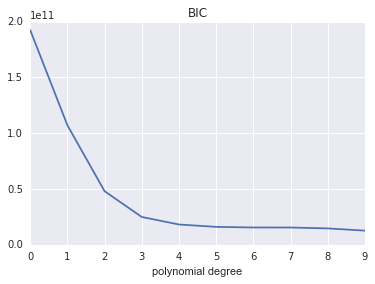

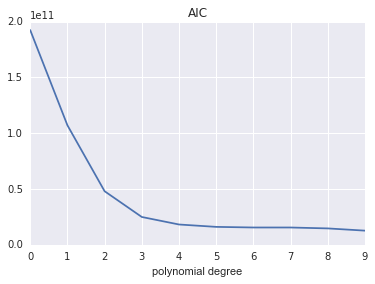

In [195]:
bic = []
for i in range(0,10):
    bic.append(BIC(log_likelihood(results[i]),i+1,len(x)))
    print "BIC for " + str(i) + " order polynomial: " + str(BIC(log_likelihood(results[i]),i+1,len(x)))

print ""
    
aic = []
for i in range(0,10):
    aic.append(AIC(log_likelihood(results[i]),i+1,len(x)))
    print "AIC for " + str(i) + " order polynomial: " + str(AIC(log_likelihood(results[i]),i+1,len(x)))
    
plt.plot(range(0,10),bic)
plt.xlabel("polynomial degree")
plt.title("BIC")
plt.show()
plt.plot(range(0,10),aic)
plt.xlabel("polynomial degree")
plt.title("AIC")
plt.show()

In [199]:
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))
#     p = np.poly1d(results[i])
#     return p(x)

def log_prior(theta):
    # size of theta determines the model.
    # flat prior over a large range
    if np.any(abs(theta) > 10000):
        return -np.inf  # log(0)
    else:
        return - np.log(2000) ** len(theta)

def log_likelihood(theta, data=data):
    x, y = data
    yM = polynomial_fit(theta, x)
    return -0.5 * np.sum(np.log(2 * np.pi)
                         + (y - yM) ** 2)

def log_posterior(theta, data=data):
    theta = np.asarray(theta)
    return log_prior(theta) + log_likelihood(theta, data)

In [210]:

import emcee

def compute_mcmc(degree, data=data,
                   log_posterior=log_posterior,
                   nwalkers=50, nburn=1000, nsteps=2000):
    ndim = degree + 1  # this determines the model
    rng = np.random.RandomState(0)
    starting_guesses = rng.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
    sampler.run_mcmc(starting_guesses, nsteps)
    trace = sampler.chain[:, nburn:, :].reshape(-1, ndim)
    return trace

trace_1D = compute_mcmc(0)
# trace_2D = compute_mcmc(1)
# trace_3D = compute_mcmc(2)
# trace_4D = compute_mcmc(3)
trace_5D = compute_mcmc(4)

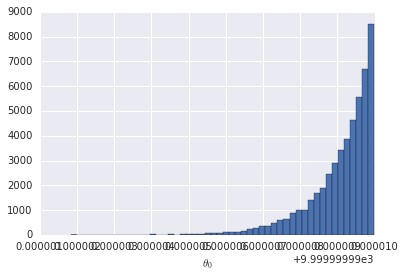

In [201]:
df_1D = pandas.DataFrame(trace_1D)
plt.hist(trace_1D,bins = 50)
plt.xlabel(r"$\theta_0$")
plt.show()

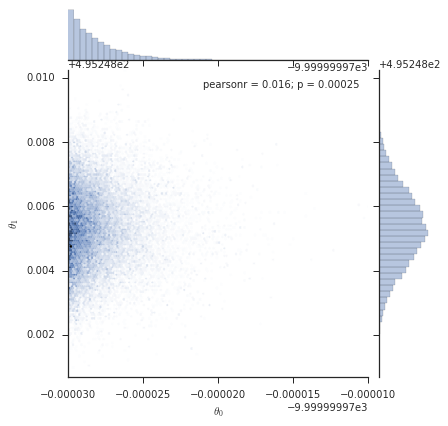

In [202]:
columns = [r'$\theta_{0}$'.format(i) for i in range(3)]
df_2D = pandas.DataFrame(trace_2D, columns=columns[:2])

with sns.axes_style('ticks'):
    jointplot = sns.jointplot(r'$\theta_0$', r'$\theta_1$',
                              data=df_2D, kind="hex");

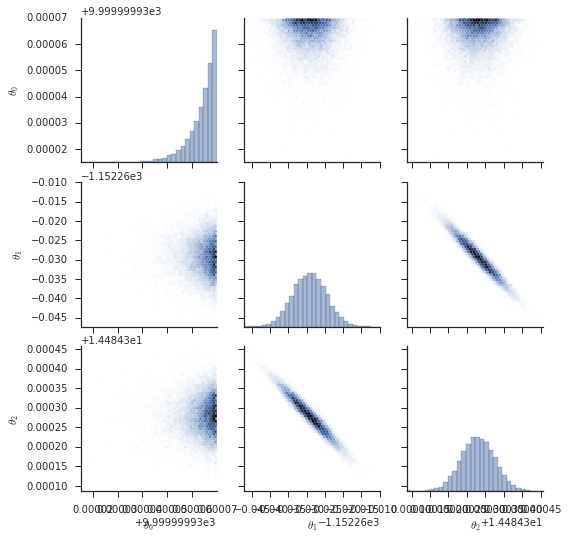

In [228]:
df_3D = pandas.DataFrame(trace_3D, columns=columns[:3])

# get the colormap from the joint plot above
cmap = jointplot.ax_joint.collections[0].get_cmap()

with sns.axes_style('ticks'):
    grid = sns.PairGrid(df_3D)
    grid.map_diag(plt.hist, bins=30, alpha=0.5)
    grid.map_offdiag(plt.hexbin, gridsize=50, linewidths=0, cmap=cmap)

In [229]:
results[4]

array([  5.30e-03,  -1.07e+00,   7.10e+01,  -1.66e+03,   8.90e+03])

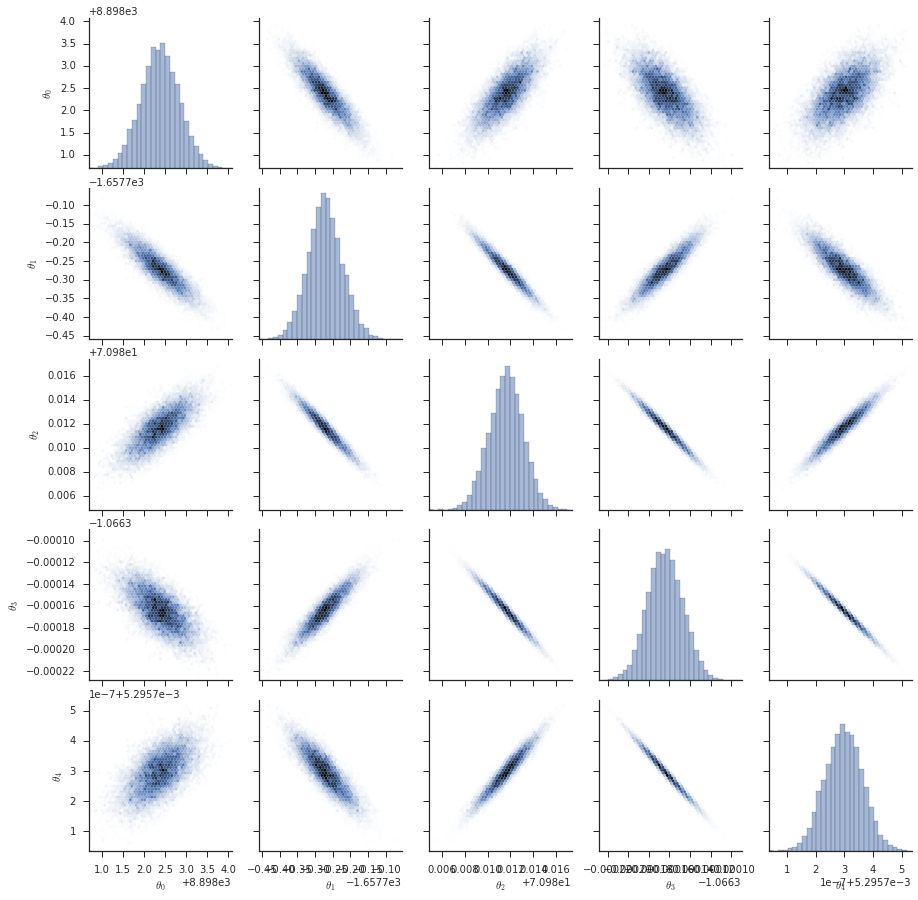

In [211]:
columns = [r'$\theta_{0}$'.format(i) for i in range(5)]
df_5D = pandas.DataFrame(trace_5D, columns=columns[:5])

# get the colormap from the joint plot above
cmap = jointplot.ax_joint.collections[0].get_cmap()

with sns.axes_style('ticks'):
    grid = sns.PairGrid(df_5D)
    grid.map_diag(plt.hist, bins=30, alpha=0.5)
    grid.map_offdiag(plt.hexbin, gridsize=50, linewidths=0, cmap=cmap)

In [226]:
from scipy import integrate

def integrate_posterior_1D(log_posterior, xlim, ylim, data=data):
    func = lambda theta0: np.exp(log_posterior([theta0], data))
    return integrate.quad(func, xlim[0], ylim[0])

def integrate_posterior_2D(log_posterior, xlim, ylim, data=data):
    func = lambda theta1, theta0: np.exp(log_posterior([theta0, theta1], data))
    return integrate.dblquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1])

def integrate_posterior_3D(log_posterior, xlim, ylim, zlim, data=data):
    func = lambda theta2, theta1, theta0: np.exp(log_posterior([theta0, theta1, theta2], data))
    return integrate.tplquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1],
                             lambda x, y: zlim[0], lambda x, y: zlim[1])

In [227]:
xlim, ylim = trace_1D.min(0), trace_1D.max(0)
%time Z0, err_Z0 = integrate_posterior_1D(log_posterior, xlim, ylim)
print("Z0 =", Z0, "+/-", err_Z0)

CPU times: user 2.11 ms, sys: 1.68 ms, total: 3.79 ms
Wall time: 5.36 ms
('Z0 =', 0.0, '+/-', 0.0)


In [208]:
xlim, ylim = zip(trace_2D.min(0), trace_2D.max(0))
%time Z1, err_Z1 = integrate_posterior_2D(log_posterior, xlim, ylim)
print("Z1 =", Z1, "+/-", err_Z1)

CPU times: user 44.8 ms, sys: 108 µs, total: 44.9 ms
Wall time: 45.2 ms
('Z1 =', 0.0, '+/-', 0.0)


In [209]:
xlim, ylim, zlim = zip(trace_3D.min(0), trace_3D.max(0))
%time Z2, err_Z2 = integrate_posterior_3D(log_posterior, xlim, ylim, zlim)
print("Z2 =", Z2, "+/-", err_Z2)

CPU times: user 902 ms, sys: 3.6 ms, total: 905 ms
Wall time: 1 s
('Z2 =', 0.0, '+/-', 0.0)


In [170]:
def best_theta(degree, model=polynomial_fit, data=data):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -log_likelihood(theta, data)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

theta0 = best_theta(0)
theta1 = best_theta(1)
theta2 = best_theta(2)

### Cross validation

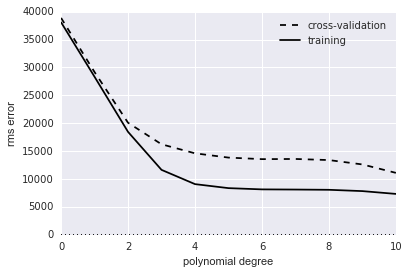

In [218]:
#FROM PROBLEM 2 OF PROBLEM SET 3

training_err = []
crossval_err = []



#split into training and cv sets
r = random.sample(range(0,len(x)),len(x))
train_indices = r[0:int(len(r)/2)]
cv_indices = r[int(len(r)/2):]
x_train = x[train_indices]
y_train = y[train_indices]
x_cv = x[cv_indices]
y_cv = y[cv_indices]

# #train model
# p = np.poly1d(np.polyfit(x_train, y_train, i))

# #apply it to train/cv data
# pred_train = p(x_train)
# pred_cv = p(x_cv)


#for every polynomial degree
for i in range(0,11):
    
    #train model
    p = np.poly1d(np.polyfit(x_train, y_train, i))

    #apply it to train/cv data
    pred_train = p(x_train)
    pred_cv = p(x_cv)
    
    
    training_err.append(np.sqrt(np.sum((np.array(pred_train) - y_train) ** 2) / len(y_train)))
    crossval_err.append(np.sqrt(np.sum((np.array(pred_cv) - y_cv) ** 2) / len(y_cv)))
    
    
#rms    
plt.plot(range(0,11), crossval_err, '--k', label='cross-validation')
plt.plot(range(0,11), training_err, '-k', label='training')
plt.plot(range(0,11), 0.1 * np.ones(11), ':k')
plt.xlabel('polynomial degree')
plt.ylabel('rms error')
plt.legend(loc='best')
plt.show()

### Learning Rate

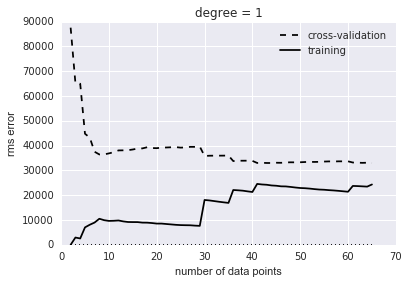

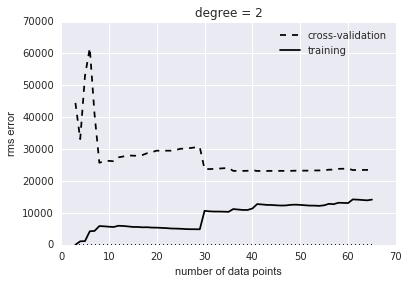

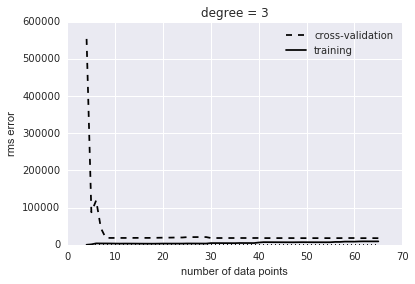

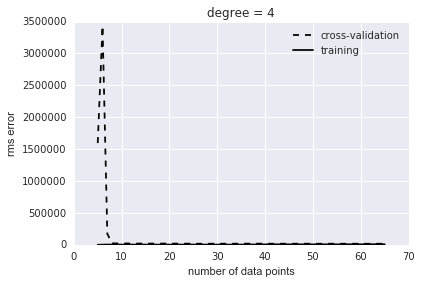

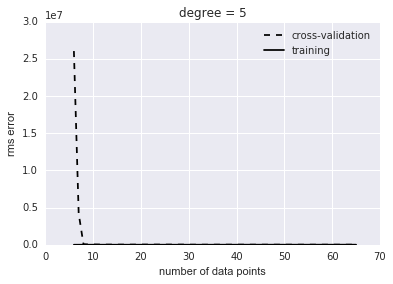

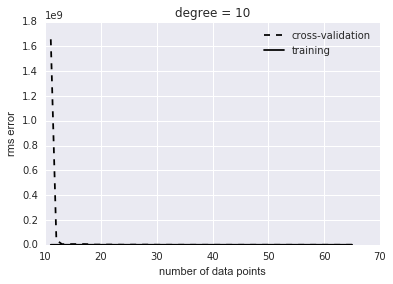

In [225]:
#FROM PROBLEM 2 OF PROBLEM SET 3


#split into training and cv sets
r = random.sample(range(0,len(x)),len(x))
train_indices = r[0:int(len(r)/2)]
cv_indices = r[int(len(r)/2):]
x_train = x[train_indices]
y_train = y[train_indices]
x_cv = x[cv_indices]
y_cv = y[cv_indices]

degrees = [1,2,3,4,5,10]

for d in degrees:
    
    
    training_err = []
    crossval_err = []
    
#     print d
    for i in range(d + 1 ,len(x_train) + 1):
        
        #train model
        p = np.poly1d(np.polyfit(x_train[:i], y_train[:i], d))
        
        #apply it to train/cv data
        pred_train = p(x_train[:i])
        pred_cv = p(x_cv)

        training_err.append(np.sqrt(np.sum((np.array(pred_train) - y_train[:i]) ** 2) / len(y_train[:i])))
        crossval_err.append(np.sqrt(np.sum((np.array(pred_cv) - y_cv) ** 2) / len(y_cv)))
    
    
    
    #rms    
    plt.plot(range(d + 1,len(x_train) + 1), crossval_err, '--k', label='cross-validation')
    plt.plot(range(d + 1,len(x_train) + 1), training_err, '-k', label='training')
    plt.plot(range(d + 1,len(x_train) + 1), 0.1 * np.ones(len(range(d + 1,len(x_train) + 1))), ':k')
    plt.xlabel('number of data points')
    plt.ylabel('rms error')
    plt.legend(loc='best')
    plt.title("degree = " + str(d))
    plt.show()

## Clustering

Discussion of ways bandwidth/k were chosen, and interpretation of results is all in the report.


Code for this and later parts based on:

http://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#example-neighbors-plot-kde-1d-py

http://www.astroml.org/book_figures/chapter6/fig_great_wall.html#book-fig-chapter6-fig-great-wall

http://www.astroml.org/modules/generated/astroML.density_estimation.KDE.html

http://scikit-learn.org/stable/auto_examples/neighbors/plot_digits_kde_sampling.html

https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

In [55]:
#gather data
clustering = final[["longitude","latitude"]]
clustering = clustering.dropna()
clustering = clustering.sample(1000)
# clustering

#combine columns
X = np.column_stack((np.array(clustering.longitude),np.array(clustering.latitude)))

Nx = 50
Ny = 50
xmin,xmax = (np.min(X[:, 0]),np.max(X[:, 0]))
ymin,ymax = (np.min(X[:, 1]),np.max(X[:, 1]))
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T


#### KDE

http://scikit-learn.org/stable/auto_examples/neighbors/plot_digits_kde_sampling.html

https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

best bandwidth: 0.428133239872


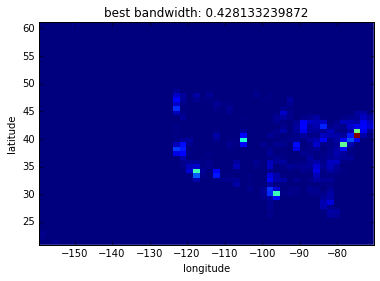

In [59]:
params = {'bandwidth': np.logspace(-1,1,20)}
grid = GridSearchCV(KernelDensity(),params,cv = 20)
grid.fit(X)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

kde = grid.best_estimator_

#see p.255 of textbook
log_dens = kde.score_samples(Xgrid).reshape((Ny,Nx))


plt.imshow(np.exp(log_dens), origin='lower',
           extent=(xmin, xmax,ymin, ymax),interpolation='none')
plt.xlabel("longitude")
plt.ylabel("latitude")

# http://stackoverflow.com/questions/24535393/matplotlib-getting-subplots-to-fill-figure
plt.axis('tight')
plt.title("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

plt.show()

#### KNN

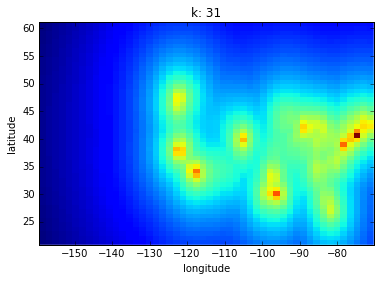

In [57]:
#see p. 258 of textbook
k = int(np.sqrt(len(X[:,0])))

knd = KNeighborsDensity("bayesian",k)
knd.fit(X)
dens = knd.eval(Xgrid).reshape((Ny,Nx))

plt.imshow(dens, origin='lower',norm=LogNorm(),
           extent=(xmin, xmax,ymin, ymax),interpolation='none')
plt.xlabel("longitude")
plt.ylabel("latitude")

# http://stackoverflow.com/questions/24535393/matplotlib-getting-subplots-to-fill-figure
plt.axis('tight')

plt.title("k: " + str(k))
plt.show()

#### K Means

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

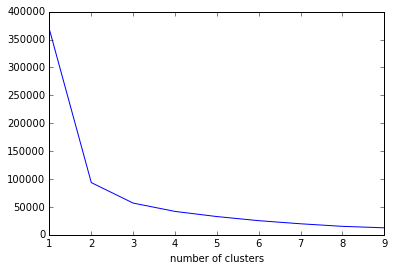

In [43]:
inertias = []
for k in np.arange(1,10):

    #see p. 271 of textbook
    clf = KMeans(n_clusters=k)
    clf.fit(X)
#     centers = clf.cluster_centers_
#     labels = clf.predict(X)
    
    inertias.append(clf.inertia_)

    #http://stackoverflow.com/questions/12487060/matplotlib-color-according-to-class-labels
#     plt.scatter(d1.S280MAG - d1.BjMAG, d1.BjMAG, c = labels)
#     plt.xlabel("M280 - MB")
#     plt.ylabel("MB")
#     plt.show()

plt.plot(np.arange(1,10),inertias)
plt.xlabel("number of clusters")
plt.show()

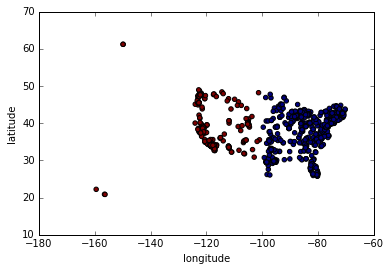

In [60]:
k = 2

#see p. 271 of textbook
clf = KMeans(n_clusters=k)
clf.fit(X)
centers = clf.cluster_centers_
labels = clf.predict(X)

#http://stackoverflow.com/questions/12487060/matplotlib-color-according-to-class-labels
plt.scatter(clustering.longitude, clustering.latitude, c = labels)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

#### MeanShift

Code based on: http://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html


best bandwidth: 13.5436462682


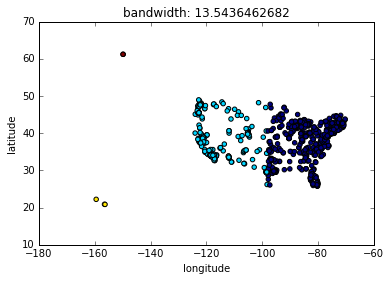

In [61]:
#http://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html
bw = estimate_bandwidth(X)
print "best bandwidth: " + str(bw)

#see p.273 of textbook
ms = MeanShift(bandwidth = bw)
ms.fit(X)
centers = ms.cluster_centers_
labels = ms.labels_

#http://stackoverflow.com/questions/12487060/matplotlib-color-according-to-class-labels
plt.scatter(clustering.longitude, clustering.latitude, c = labels)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("bandwidth: " + str(bw))
plt.show()

## Classification

#### Much of the modeling code in this section is adapted from Chapter 9 of the textbook.

### Predicting the Candidate

In [81]:
classification = final_even[["cand_nm","longitude","latitude","contb_receipt_amt","relative_date_int","day_of_month","year","month_int","contbr_employer","contbr_occupation"]]
classification = classification.dropna()
# classification = classification.sample(10000)

train_split = 0.8
# http://stackoverflow.com/questions/19597473/binary-random-array-with-a-specific-proportion-of-ones
train_indices = np.array([1] * int(round(train_split * len(classification.cand_nm))) + [0] * int(round((1 - train_split) * len(classification.cand_nm))))
np.random.shuffle(train_indices)
# train_indices = np.random.randint(0,2,len(classification.cand_nm))
train = classification[np.logical_not(np.logical_not(train_indices))]
test = classification[np.logical_not(train_indices)]


Xtrain_num = np.column_stack((np.array(train.longitude),np.array(train.latitude),np.array(train.contb_receipt_amt),np.array(train.relative_date_int)))
Xtrain_all = np.column_stack((np.array(train.longitude),np.array(train.latitude),np.array(train.contb_receipt_amt),np.array(train.relative_date_int),np.array(train.contbr_employer),np.array(train.contbr_occupation)))
ytrain = train.cand_nm
Xtest_num = np.column_stack((np.array(test.longitude),np.array(test.latitude),np.array(test.contb_receipt_amt),np.array(test.relative_date_int)))
Xtest_all = np.column_stack((np.array(test.longitude),np.array(test.latitude),np.array(test.contb_receipt_amt),np.array(test.relative_date_int),np.array(test.contbr_employer),np.array(test.contbr_occupation)))
ytest = test.cand_nm


In [64]:
# VERY HELPFUL LINK: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(ytest)))
    plt.xticks(tick_marks, np.unique(ytest), rotation=45)
    plt.yticks(tick_marks, np.unique(ytest))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion(ytest,y_pred, modelname):
    cm = metrics.confusion_matrix(ytest,y_pred,labels=np.unique(ytest))
    np.set_printoptions(precision=2)
    # print('Confusion matrix, without normalization')
    # print(cm)
    plt.figure(figsize=(7,7))
    plot_confusion_matrix(cm, title = 'Confusion matrix for ' + modelname)
    plt.show()

#     cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     # print('Normalized confusion matrix')
#     # print(cm_normalized)
#     plt.figure(figsize=(7,7))
#     plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix for ' + modelname)
#     plt.show()
    


#### RandomForest

classification rate for 1 trees = 0.354870032865
classification rate for 11 trees = 0.428443382133
classification rate for 21 trees = 0.436062145205
classification rate for 31 trees = 0.442560501942
classification rate for 41 trees = 0.446892739767
classification rate for 51 trees = 0.447639677323
classification rate for 61 trees = 0.449805796235
classification rate for 71 trees = 0.449208246191
classification rate for 81 trees = 0.449282939946
classification rate for 91 trees = 0.450179265013
classification rate for 101 trees = 0.449805796235


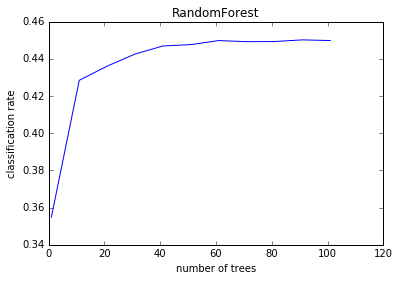

In [65]:
results = []
for num_tree in np.arange(1,102,10):   
    model = RandomForestClassifier(n_estimators = num_tree)
    model.fit(Xtrain_num,ytrain)
    y_pred = model.predict(Xtest_num)
    results.append(float(np.sum(y_pred == ytest))/len(y_pred))
    print("classification rate for " +str(num_tree) +" trees = " + str(float(np.sum(y_pred == ytest))/len(y_pred)))
plt.plot(np.arange(1,102,10), results)
plt.xlabel("number of trees")
plt.ylabel("classification rate")
plt.title("RandomForest")
plt.show()

classification rate for 100 trees = 0.449058858679


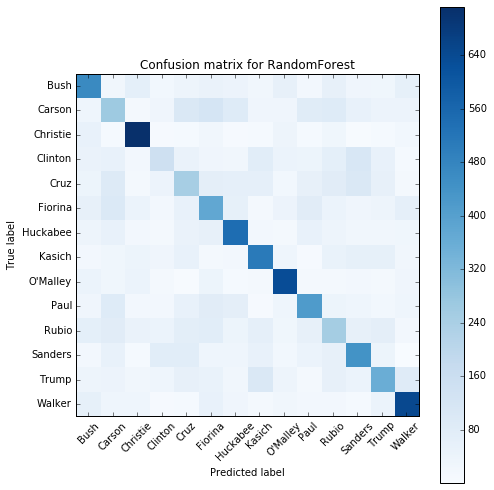

In [66]:
num_tree = 100
model = RandomForestClassifier(n_estimators = num_tree)
model.fit(Xtrain_num,ytrain)
y_pred = model.predict(Xtest_num)
print("classification rate for " +str(num_tree) +" trees = " + str(float(np.sum(y_pred == ytest))/len(y_pred)))
confusion(ytest, y_pred, 'RandomForest')

#### Gradient Boosted Trees

classification rate for max depth 1 = 0.344
classification rate for max depth 2 = 0.3885
classification rate for max depth 3 = 0.4115
classification rate for max depth 4 = 0.4135
classification rate for max depth 5 = 0.417
classification rate for max depth 6 = 0.4185
classification rate for max depth 7 = 0.4165
classification rate for max depth 8 = 0.3955
classification rate for max depth 9 = 0.394


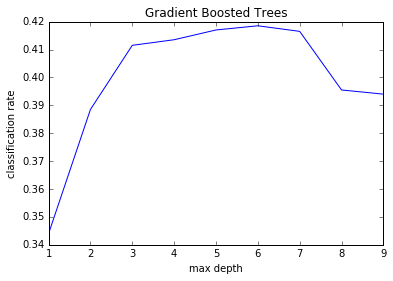

In [78]:
results = []
for md in np.arange(1,10):
    model = GradientBoostingClassifier(max_depth=md)
    model.fit(Xtrain_num,ytrain)
    y_pred = model.predict(Xtest_num)
    results.append(float(np.sum(y_pred == ytest))/len(y_pred))
    print("classification rate for max depth " + str(md) + " = " + str(float(np.sum(y_pred == ytest))/len(y_pred)))
    
plt.plot(np.arange(1,10), results)
plt.xlabel("max depth")
plt.ylabel("classification rate")
plt.title("Gradient Boosted Trees")
plt.show()

classification rate for max depth 6 = 0.4095


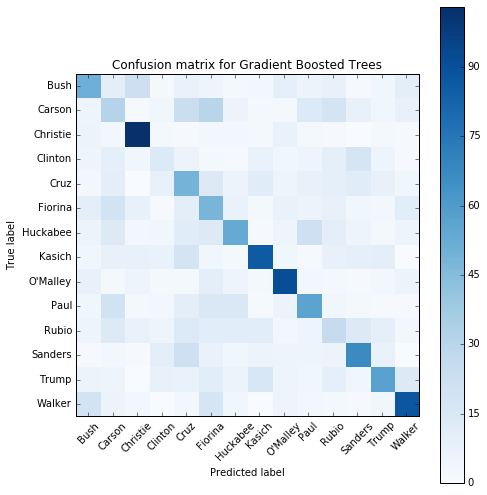

In [79]:
md = 6

model = GradientBoostingClassifier(max_depth=md)
model.fit(Xtrain_num,ytrain)
y_pred = model.predict(Xtest_num)
print("classification rate for max depth " + str(md) + " = " + str(float(np.sum(y_pred == ytest))/len(y_pred)))
confusion(ytest, y_pred, 'Gradient Boosted Trees')

#### KNN Classification

classification rate with k of 1 = 0.343964744547
classification rate with k of 11 = 0.353376157753
classification rate with k of 21 = 0.348147594861
classification rate with k of 31 = 0.340454138034
classification rate with k of 41 = 0.335225575142
classification rate with k of 51 = 0.331939049895
classification rate with k of 61 = 0.326038243203
classification rate with k of 71 = 0.326411711981
classification rate with k of 81 = 0.322826411712
classification rate with k of 91 = 0.321631311622
classification rate with k of 101 = 0.319763967732


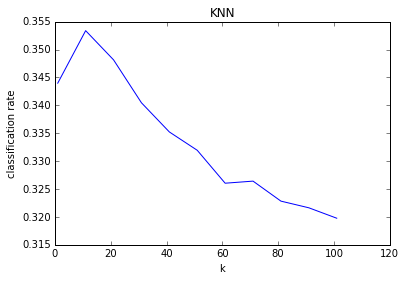

In [82]:
results = []
for k in np.arange(1,102,10):
    model = KNeighborsClassifier(k)
    model.fit(Xtrain_num,ytrain)
    y_pred = model.predict(Xtest_num)
    results.append(float(np.sum(y_pred == ytest))/len(y_pred))
    print("classification rate with k of " + str(k) + " = " + str(float(np.sum(y_pred == ytest))/len(y_pred)))
plt.plot(np.arange(1,102,10), results)
plt.xlabel("k")
plt.ylabel("classification rate")
plt.title("KNN")
plt.show()

classification rate with k of 10 = 0.351434120108


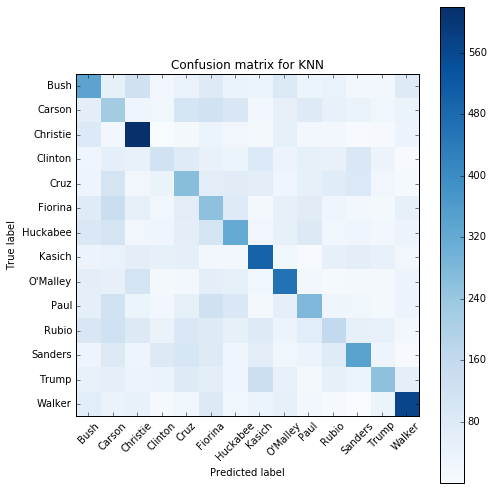

In [84]:
k = 10

model = KNeighborsClassifier(k)
model.fit(Xtrain_num,ytrain)
y_pred = model.predict(Xtest_num)
print("classification rate with k of " + str(k) + " = " + str(float(np.sum(y_pred == ytest))/len(y_pred)))
confusion(ytest, y_pred, 'KNN')

#### Gaussian Naive Bayes

classification rate = 0.200702121303


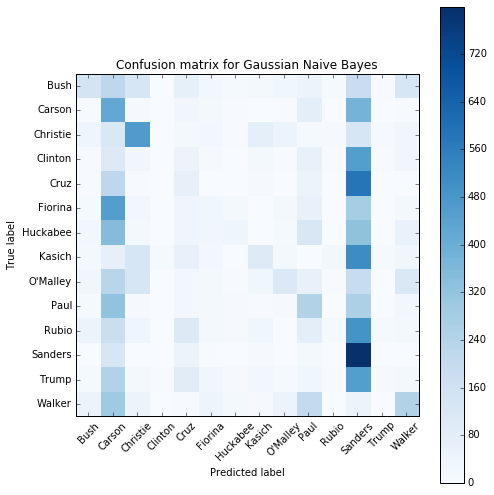

In [85]:
model = GaussianNB()
model.fit(Xtrain_num,ytrain)
y_pred = model.predict(Xtest_num)
print("classification rate = " + str(float(np.sum(y_pred == ytest))/len(y_pred)))
confusion(ytest, y_pred, 'Gaussian Naive Bayes')

In [91]:
print len(ytest.value_counts())
print float(pandas.Series(y_pred).value_counts()['Sanders'])/len(y_pred)
print float(pandas.Series(y_pred).value_counts()['Carson'])/len(y_pred)

14
0.380116522259
0.25


#### Random

classification rate = 0.0724204867851


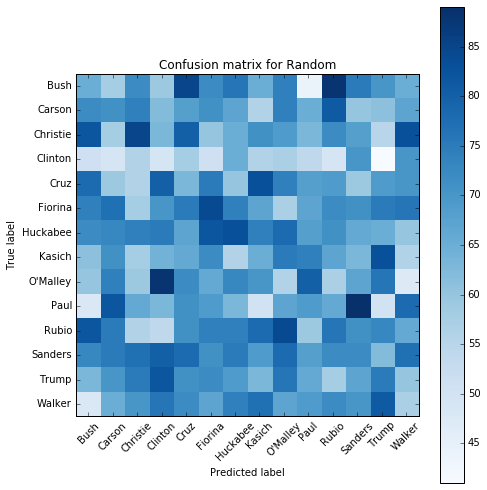

In [164]:
cand_options = ytrain.unique()
y_pred = np.random.choice(cand_options,len(ytest),replace=True)
print("classification rate = " + str(float(np.sum(y_pred == ytest))/len(y_pred)))
confusion(ytest, y_pred, 'Random')

### Predicting Sanders vs. Clinton

In [100]:
classification = final_clinton_sanders[["cand_nm","longitude","latitude","contb_receipt_amt","relative_date_int","day_of_month","year","month_int","contbr_employer","contbr_occupation"]]
classification = classification.dropna()
# classification = classification.sample(100000)

train_split = 0.8
# http://stackoverflow.com/questions/19597473/binary-random-array-with-a-specific-proportion-of-ones
train_indices = np.array([1] * int(round(train_split * len(classification.cand_nm))) + [0] * int(round((1 - train_split) * len(classification.cand_nm))))
np.random.shuffle(train_indices)
# train_indices = np.random.randint(0,2,len(classification.cand_nm))
train = classification[np.logical_not(np.logical_not(train_indices))]
test = classification[np.logical_not(train_indices)]


Xtrain_num = np.column_stack((np.array(train.longitude),np.array(train.latitude),np.array(train.contb_receipt_amt),np.array(train.relative_date_int)))
Xtrain_all = np.column_stack((np.array(train.longitude),np.array(train.latitude),np.array(train.contb_receipt_amt),np.array(train.relative_date_int),np.array(train.contbr_employer),np.array(train.contbr_occupation)))
ytrain = train.cand_nm
Xtest_num = np.column_stack((np.array(test.longitude),np.array(test.latitude),np.array(test.contb_receipt_amt),np.array(test.relative_date_int)))
Xtest_all = np.column_stack((np.array(test.longitude),np.array(test.latitude),np.array(test.contb_receipt_amt),np.array(test.relative_date_int),np.array(test.contbr_employer),np.array(test.contbr_occupation)))
ytest = test.cand_nm

#### RandomForest

classification rate for 1 trees = 0.709761088216
classification rate for 11 trees = 0.757658722153
classification rate for 21 trees = 0.763941323957
classification rate for 31 trees = 0.764719444364
classification rate for 41 trees = 0.766852070665
classification rate for 51 trees = 0.768782962045
classification rate for 61 trees = 0.768062480187
classification rate for 71 trees = 0.768465950027
classification rate for 81 trees = 0.769301708983
classification rate for 91 trees = 0.76835067293
classification rate for 101 trees = 0.769042335514


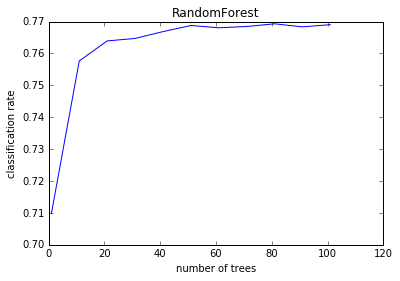

In [93]:
results = []
for num_tree in np.arange(1,102,10):   
    model = RandomForestClassifier(n_estimators = num_tree)
    model.fit(Xtrain_num,ytrain)
    y_pred = model.predict(Xtest_num)
    results.append(float(np.sum(y_pred == ytest))/len(y_pred))
    print("classification rate for " +str(num_tree) +" trees = " + str(float(np.sum(y_pred == ytest))/len(y_pred)))
plt.plot(np.arange(1,102,10), results)
plt.xlabel("number of trees")
plt.ylabel("classification rate")
plt.title("RandomForest")
plt.show()

classification rate for 80 trees = 0.768667684948


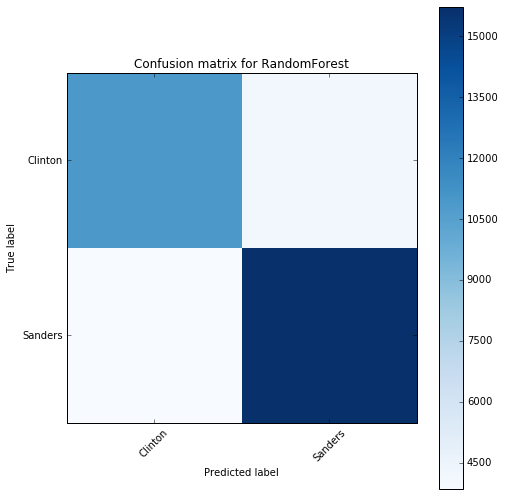

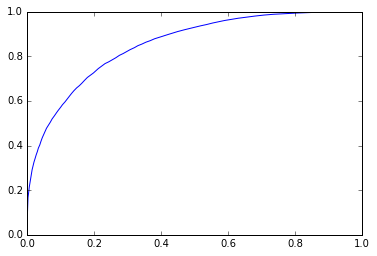

In [95]:
num_tree = 80
model = RandomForestClassifier(n_estimators = num_tree)
model.fit(Xtrain_num,ytrain)
y_pred = model.predict(Xtest_num)
print("classification rate for " +str(num_tree) +" trees = " + str(float(np.sum(y_pred == ytest))/len(y_pred)))
confusion(ytest, y_pred, 'RandomForest')


#VERY HELPFUL LINK: http://www.astroml.org/book_figures/chapter9/fig_ROC_curve.html
prob = model.predict_proba(Xtest_num)
tpr_rf, fpr_rf, thresh_rf = metrics.roc_curve(ytest, prob[:, 0],pos_label="Sanders")
plt.plot(fpr_rf,tpr_rf)
plt.show()

#### Gradient Boosted Trees

classification rate for max depth 1 = 0.667627309144
classification rate for max depth 2 = 0.74146228998
classification rate for max depth 3 = 0.755583734402
classification rate for max depth 4 = 0.767140263408
classification rate for max depth 5 = 0.774114527796
classification rate for max depth 6 = 0.778725611689
classification rate for max depth 7 = 0.784547105104
classification rate for max depth 8 = 0.78771722528
classification rate for max depth 9 = 0.790858526182


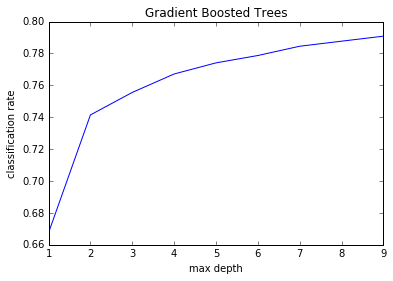

In [101]:
results = []
for md in np.arange(1,10):
    model = GradientBoostingClassifier(max_depth=md)
    model.fit(Xtrain_num,ytrain)
    y_pred = model.predict(Xtest_num)
    results.append(float(np.sum(y_pred == ytest))/len(y_pred))
    print("classification rate for max depth " + str(md) + " = " + str(float(np.sum(y_pred == ytest))/len(y_pred)))
    
plt.plot(np.arange(1,10), results)
plt.xlabel("max depth")
plt.ylabel("classification rate")
plt.title("Gradient Boosted Trees")
plt.show()

classification rate for max depth 9 = 0.790426237067


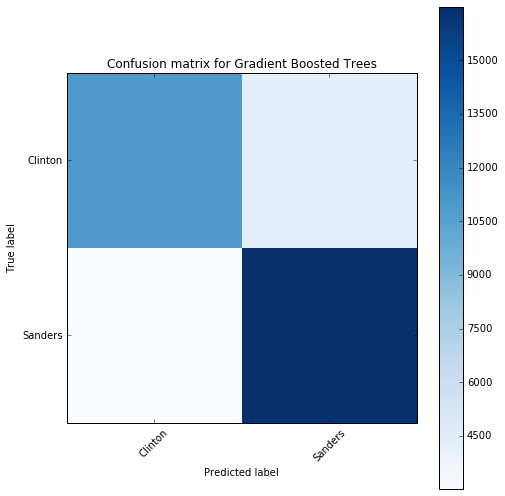

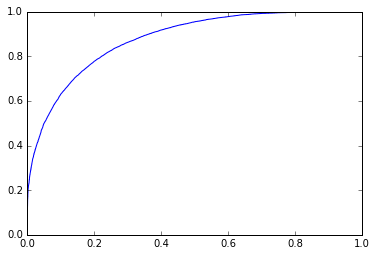

In [102]:
md = 9


model = GradientBoostingClassifier(max_depth=md)
model.fit(Xtrain_num,ytrain)
y_pred = model.predict(Xtest_num)
results.append(float(np.sum(y_pred == ytest))/len(y_pred))
print("classification rate for max depth " + str(md) + " = " + str(float(np.sum(y_pred == ytest))/len(y_pred)))
confusion(ytest, y_pred, 'Gradient Boosted Trees')

#VERY HELPFUL LINK: http://www.astroml.org/book_figures/chapter9/fig_ROC_curve.html
prob = model.predict_proba(Xtest_num)
tpr_gb, fpr_gb, thresh_gb = metrics.roc_curve(ytest, prob[:, 0],pos_label="Sanders")
plt.plot(fpr_gb,tpr_gb)
plt.show()

#### KNN Classification

classification rate with k of 1 = 0.700221908412
classification rate with k of 11 = 0.730539785008
classification rate with k of 21 = 0.724977665062
classification rate with k of 31 = 0.7233637857
classification rate with k of 41 = 0.718089858497
classification rate with k of 51 = 0.715265569613
classification rate with k of 61 = 0.710827401366
classification rate with k of 71 = 0.708464220871
classification rate with k of 81 = 0.706187498199
classification rate with k of 91 = 0.704948269403
classification rate with k of 101 = 0.703478486412


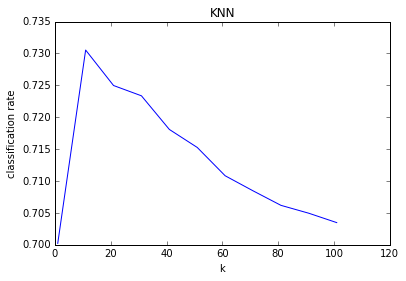

In [103]:
results = []
for k in np.arange(1,102,10):
    model = KNeighborsClassifier(k)
    model.fit(Xtrain_num,ytrain)
    y_pred = model.predict(Xtest_num)
    results.append(float(np.sum(y_pred == ytest))/len(y_pred))
    print("classification rate with k of " + str(k) + " = " + str(float(np.sum(y_pred == ytest))/len(y_pred)))
plt.plot(np.arange(1,102,10), results)
plt.xlabel("k")
plt.ylabel("classification rate")
plt.title("KNN")
plt.show()

classification rate with k of 10 = 0.726735640797


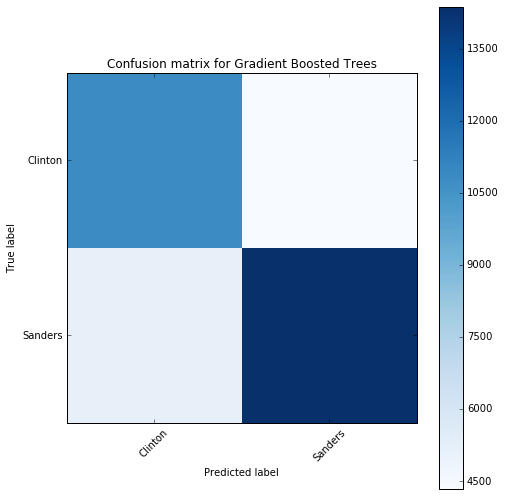

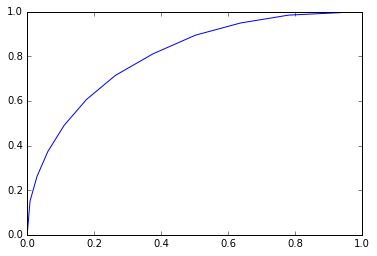

In [104]:
k = 10
model = KNeighborsClassifier(k)
model.fit(Xtrain_num,ytrain)
y_pred = model.predict(Xtest_num)
results.append(float(np.sum(y_pred == ytest))/len(y_pred))
print("classification rate with k of " + str(k) + " = " + str(float(np.sum(y_pred == ytest))/len(y_pred)))
confusion(ytest, y_pred, 'Gradient Boosted Trees')

#VERY HELPFUL LINK: http://www.astroml.org/book_figures/chapter9/fig_ROC_curve.html
prob = model.predict_proba(Xtest_num)
tpr_knn, fpr_knn, thresh_knn = metrics.roc_curve(ytest, prob[:, 0],pos_label="Sanders")
plt.plot(fpr_knn,tpr_knn)
plt.show()

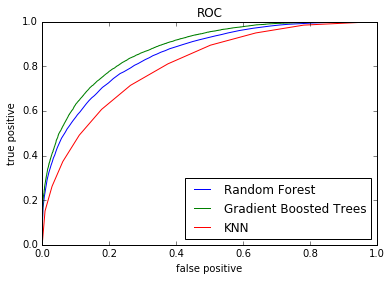

In [109]:
#VERY HELPFUL LINK: http://www.astroml.org/book_figures/chapter9/fig_ROC_curve.html
plt.plot(fpr_rf,tpr_rf,label="Random Forest")
plt.plot(fpr_gb,tpr_gb,label="Gradient Boosted Trees")
plt.plot(fpr_knn,tpr_knn,label="KNN")
plt.xlabel("false positive")
plt.ylabel("true positive")
plt.title("ROC")
plt.legend(loc="best")
plt.show()